## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)



### Introduction

A/B tests are very commonly performed to test the performance of an old website page compared to a newly developed website page using bootstrapping for hypothesis testing. we also apply logistic regression .
<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [49]:
#Loading dataset to dataframe
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [7]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
len(df.query("(group != 'treatment' and landing_page=='new_page') or ( group == 'treatment' and landing_page !='new_page')"))


3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.duplicated(['user_id'])]['user_id'].unique()

array([773192])

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
# dropping the duplicates
df2 = df2.drop_duplicates(['user_id'], keep='first')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
# mean of dataframe after dropping nulls
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_convert = df2.query("group =='control'").converted.mean()
control_convert

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treat_convert = df2[df2["group"] =='treatment']['converted'].mean()
treat_convert 

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
len(df2.query("landing_page == 'new_page'"))/len(df2)

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

These results suggest that there is not sufficient evidence to say that the treatment page leads to more conversions as the probability of conversion for the treatment group is less than that for the control group.

<a id='ab_test'></a>
### Part II - A/B Test

Hypotheses


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Hypothesis:

$$H_{0} : p_{new} - p_{old} \le 0$$
$$H_{1} : p_{new} - p_{old} \gt 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new =  df2.query('landing_page == "new_page"').shape[0]
n_new


145310

d. What is $n_{old}$?

In [23]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[p_new, (1-p_new)])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[p_old, (1-p_old)])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.00026362870528484628

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [27]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[p_new, (1-p_new)]).mean()
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[p_old, (1-p_old)]).mean()
    diff = new_page_converted - old_page_converted 
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

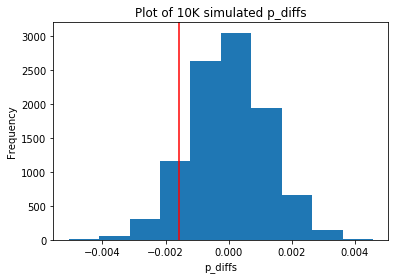

In [28]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot of 10K simulated p_diffs')
plt.axvline(treat_convert - control_convert, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
act_diff = treat_convert -  control_convert
act_diff

-0.0015782389853555567

In [30]:
p_diffs = np.array(p_diffs)
p_diffs

array([ -5.98637646e-05,  -5.41616358e-04,   4.49371844e-04, ...,
        -6.51768413e-04,   1.37186227e-03,  -3.41857146e-04])

In [31]:
(act_diff < p_diffs).mean()

0.90720000000000001

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<b>Results:</b> The p-value calculated is 0.9065. This is far greater than the typical $\alpha$ level of 0.05 in business studies. (An $\alpha$ level of 0.05 indicates that we have a 5% chance of committing a Type I error if the null is true.) As such, we would fail to reject the null and conclude that there is not sufficient evidence to say that that there is a difference between the two values.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old =  df2.query('group == "control" & converted == 1')['converted'].count()
convert_new =  df2.query('group == "treatment" & converted == 1')['converted'].count()
n_old = df2.query('landing_page == "new_page"').shape[0]
n_new = df2.query('landing_page == "old_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.2616957421858055, 0.89647085519672265)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The calculated values align with those obtained during the bootstrapped hypothesis testing.



<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<b>Logistic Regression</b>

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [50]:
#Instantiate and fit the model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
# Workaround for known bug with .summary() with updated scipy
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        20:21:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value 0.190 here remains above an $\alpha$ level of 0.05 but is different because this is a two tailed test. We will still reject the null in this situation.

In [38]:
# Calculate area of lower tail
p_lower = (p_diffs < act_diff).mean()

# Calculate area of upper tail
upper = p_diffs.mean() - act_diff
p_upper = (p_diffs > upper).mean()

# Calculate total tail area
p_lower + p_upper

0.18659999999999999

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Considering other factors is a good idea as these factors may contribute to the significance of our test results and leads to more accurate decisions. One of the disadvantages of adding additional terms into the regression model is Simpson's paradox where the combined impact of different variables disappears or reverses when these variables are combined, but appears where these variables are tested individually.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries_df = pd.read_csv('countries.csv')
# Making an inner join by using two dataframes
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [42]:
# finding unique countries in a column
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [44]:
# creating dummies
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [51]:
# applying logistic regression and diplaying the result summary
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 05 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        21:51:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

Once again, the p-values are greater than $\alpha$ And so we fail to reject the null. tthere is no significant contribution from country to differences in conversion rates for the two pages

In [47]:
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [56]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_page', 'UK_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 05 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        21:56:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

<b>Result:</b> None of the considered variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

<b>Resources:</b>
https://classroom.udacity.com/courses/ud257
https://www.scipy-lectures.org/packages/statistics/index.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
http://www.win-vector.com/blog/2015/06/designing-ab-tests/

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])